<a href="https://colab.research.google.com/github/vanstevanzaky/PEMB_MESIN_LEARING_TI_25-26/blob/main/UTS_Stevan%20Zaky%20S_28_TI-3A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analisis Warna Daun (RGB) - Clustering dengan K-Means dan HDBSCAN

## pip install

In [1]:
pip install pandas numpy matplotlib seaborn scikit-learn hdbscan annoy openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 12.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp312-cp312-linux_x86_64.whl size=551809 sha256=e2bb2744af33a594dbcd0dca705a2fb9775003b81021ff4aeea7e7bf3d784b7b
  Stored in directory: /root/.cache/pip/wheels/db/b9/53/a3b2d1fe1743abadddec6aa541294b24fdbc39d7800bc57311
Successfully built annoy


## 1. PREPROCESSING DATA

In [4]:
# ===================================================================
# UTS Studi Kasus - Analisis Warna Daun (RGB)
# Clustering dengan K-Means dan HDBSCAN (Absen Genap)
# ===================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score
import hdbscan
from annoy import AnnoyIndex
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')

1. PREPROCESSING DATA


### 1.1 Import Data

In [5]:
print("\n1.1 Import Data")
print("-" * 70)

df = pd.read_excel('Analisis_RGB_Warna_Daun.xlsx', skiprows=2, header=0)
df.columns = df.iloc[0].values
df = df.iloc[1:].reset_index(drop=True)

# Ambil kolom R, G, B dan konversi ke numerik
df_rgb = df[['R', 'G', 'B']].apply(pd.to_numeric, errors='coerce').dropna()

print(f"✓ Dataset berhasil diimport")
print(f"  Jumlah sampel: {len(df_rgb)}")
print(f"  Fitur utama: R, G, B")
print(f"\nStatistik Deskriptif:")
print(df_rgb.describe())


1.1 Import Data
----------------------------------------------------------------------
✓ Dataset berhasil diimport
  Jumlah sampel: 1389
  Fitur utama: R, G, B

Statistik Deskriptif:
                 R            G            B
count  1389.000000  1389.000000  1389.000000
mean    147.875450   150.247516   115.095810
std       7.141401     6.695496    15.698263
min     125.000000   129.800000    69.220000
25%     144.000000   149.000000   103.020000
50%     147.000000   151.400000   113.160000
75%     151.000000   153.800000   130.060000
max     174.000000   175.400000   157.100000


### Penjelasan Dataset

Dataset ini berisi data warna daun dalam format RGB. Tujuan analisis ini adalah untuk melakukan clustering pada data warna daun menggunakan metode K-Means dan HDBSCAN, serta mengimplementasikan Approximate Nearest Neighbor (ANN) untuk mencari tetangga terdekat.

*   **Jumlah Sampel:** Data ini memiliki total 1389 sampel (setelah penanganan missing values).
*   **Fitur:** Fitur utama dalam dataset ini adalah nilai warna **R** (Red), **G** (Green), dan **B** (Blue). Setelah preprocessing, ditambahkan fitur turunan seperti ExG, Greenness, Intensity, dan GR_Ratio.
*   **Tipe Data:** Semua fitur yang digunakan untuk clustering adalah numerik (float).

### 1.2 Tangani Missing Values

In [6]:
print("\n1.2 Tangani Missing Values")
print("-" * 70)
print(f"✓ Missing values sudah ditangani saat import")
print(f"  (menggunakan dropna setelah konversi numerik)")


1.2 Tangani Missing Values
----------------------------------------------------------------------
✓ Missing values sudah ditangani saat import
  (menggunakan dropna setelah konversi numerik)


dropna() adalah fungsi dari library pandas di Python. Fungsi ini digunakan untuk menghapus baris atau kolom dari DataFrame yang mengandung nilai-nilai yang hilang atau "NaN" (Not a Number).

### 1.3 Pembuatan Fitur Baru

In [8]:
print("\n1.4 Pembuatan Fitur Baru")
print("-" * 70)

df_rgb['ExG'] = 2 * df_rgb['G'] - df_rgb['R'] - df_rgb['B']
df_rgb['Greenness'] = (df_rgb['G'] - df_rgb['R']) / (df_rgb['R'] + df_rgb['G'] + df_rgb['B'])
df_rgb['Intensity'] = (df_rgb['R'] + df_rgb['G'] + df_rgb['B']) / 3
df_rgb['GR_Ratio'] = df_rgb['G'] / (df_rgb['R'] + 1)

print(f"✓ Fitur baru berhasil dibuat:")
print(f"  - ExG = 2*G - R - B")
print(f"  - Greenness = (G - R) / (R + G + B)")
print(f"  - Intensity = (R + G + B) / 3")
print(f"  - GR_Ratio = G / (R + 1)")


1.4 Pembuatan Fitur Baru
----------------------------------------------------------------------
✓ Fitur baru berhasil dibuat:
  - ExG = 2*G - R - B
  - Greenness = (G - R) / (R + G + B)
  - Intensity = (R + G + B) / 3
  - GR_Ratio = G / (R + 1)


Pada langkah ini, dibuat fitur-fitur baru dari nilai RGB asli untuk menangkap karakteristik warna daun yang lebih kompleks. Fitur yang ditambahkan meliputi ExG, Greenness, Intensity, dan GR_Ratio.

### 1.4 Normalisasi/Standarisasi (lanjutan)

In [10]:
print("\n1.4 Normalisasi/Standarisasi (lanjutan)")
print("-" * 70)

scaler = StandardScaler()
feature_cols = ['R', 'G', 'B', 'ExG', 'Greenness', 'Intensity', 'GR_Ratio']
df_scaled = pd.DataFrame(scaler.fit_transform(df_rgb[feature_cols]), columns=feature_cols)

print(f"✓ Standarisasi berhasil dilakukan")
print(f"  Metode: StandardScaler (mean=0, std=1)")
print(f"  Total fitur: {len(feature_cols)}")


1.4 Normalisasi/Standarisasi (lanjutan)
----------------------------------------------------------------------
✓ Standarisasi berhasil dilakukan
  Metode: StandardScaler (mean=0, std=1)
  Total fitur: 7


Data dinormalisasi menggunakan StandardScaler agar setiap fitur memiliki rata-rata 0 dan standar deviasi 1. Ini penting untuk proses selanjutnya yaitu algoritma clustering yang sensitif terhadap skala fitur.

## 2. CLUSTERING

### 2.1 Terapkan K-Means


2.1 Terapkan K-Means dan HDBSCAN
----------------------------------------------------------------------

[A] K-MEANS CLUSTERING


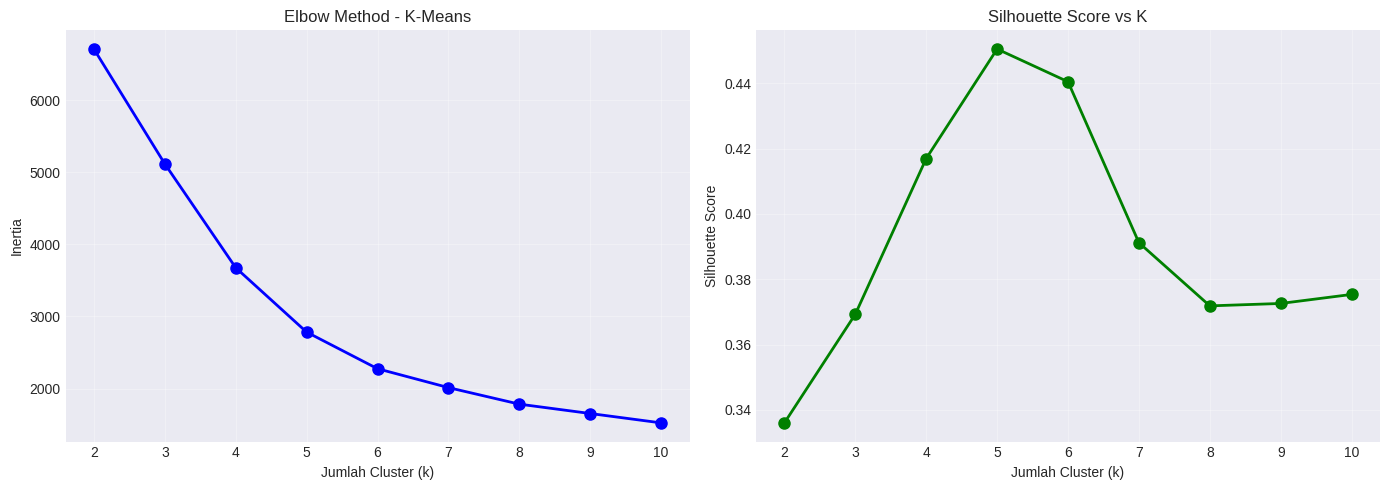

✓ K-Means clustering selesai (k=3)
  Distribusi cluster: {np.int32(0): np.int64(837), np.int32(1): np.int64(488), np.int32(2): np.int64(64)}


In [12]:
print("\n2.1 Terapkan K-Means")
print("-" * 70)

# K-MEANS
print("\n[A] K-MEANS CLUSTERING")

# Elbow Method untuk menentukan k optimal
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_temp.fit(df_scaled)
    inertias.append(kmeans_temp.inertia_)
    silhouette_scores.append(silhouette_score(df_scaled, kmeans_temp.labels_))

# Visualisasi Elbow Method
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Jumlah Cluster (k)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method - K-Means')
ax1.grid(True, alpha=0.3)

ax2.plot(K_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
ax2.set_xlabel('Jumlah Cluster (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score vs K')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('elbow_method.png', dpi=300, bbox_inches='tight')
plt.show()

# Terapkan K-Means dengan k optimal
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(df_scaled)

print(f"✓ K-Means clustering selesai (k={optimal_k})")
print(f"  Distribusi cluster: {dict(zip(*np.unique(kmeans_labels, return_counts=True)))}")

Kode ini menjalankan proses K-Means Clustering dan menggunakan Elbow Method serta Silhouette Score untuk membantu menentukan jumlah cluster (k) yang optimal.

**Analisa Output Singkat:**

*   Grafik Elbow Method dan Silhouette Score digunakan untuk memilih nilai `k` yang terbaik. Dalam kasus ini, `k=3` dipilih sebagai jumlah cluster optimal.
*   Output menunjukkan bahwa K-Means dengan `k=3` membagi data menjadi 3 cluster dengan jumlah sampel 837, 488, dan 64.

Kode ini berhasil menerapkan K-Means dan menampilkan distribusi sampel di cluster yang terbentuk.

### 2.2 Terapkan HDBSCAN

In [13]:
# HDBSCAN
print("\n[B] HDBSCAN CLUSTERING")

hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=3, metric='euclidean')
hdbscan_labels = hdbscan_clusterer.fit_predict(df_scaled)

n_clusters_hdb = len(np.unique(hdbscan_labels[hdbscan_labels != -1]))
n_noise = (hdbscan_labels == -1).sum()

print(f"✓ HDBSCAN clustering selesai")
print(f"  Jumlah cluster: {n_clusters_hdb}")
print(f"  Noise points: {n_noise} ({n_noise/len(hdbscan_labels)*100:.1f}%)")


[B] HDBSCAN CLUSTERING
✓ HDBSCAN clustering selesai
  Jumlah cluster: 95
  Noise points: 166 (12.0%)


Kode ini menjalankan proses HDBSCAN Clustering pada data yang sudah distandarisasi (`df_scaled`).

**Analisa Output Singkat:**

*   Output menunjukkan bahwa HDBSCAN mendeteksi **95 cluster** yang berbeda dalam data. Jumlah cluster yang jauh lebih banyak dibandingkan K-Means (3 cluster) mengindikasikan bahwa data warna daun ini mungkin memiliki struktur kepadatan yang lebih kompleks dan terpecah menjadi banyak kelompok yang lebih kecil dan padat.
*   HDBSCAN juga mengidentifikasi **166 titik** sebagai *noise* (sekitar 12.0% dari total sampel). Titik-titik ini adalah data yang tidak cukup padat untuk dimasukkan ke dalam cluster mana pun. Ini adalah salah satu keunggulan HDBSCAN karena secara eksplisit menangani outlier atau data yang tidak termasuk dalam kelompok yang jelas.

Dibandingkan K-Means, HDBSCAN memberikan pandangan yang lebih granular tentang struktur data dan mampu mengidentifikasi titik-titik yang tidak cocok dengan cluster mana pun.

### 2.3 Bandingkan Hasil Clustering

In [14]:
print("\n2.2 Bandingkan Hasil Clustering")
print("-" * 70)

# Evaluasi K-Means
kmeans_sil = silhouette_score(df_scaled, kmeans_labels)
kmeans_dbi = davies_bouldin_score(df_scaled, kmeans_labels)

print(f"\n[A] K-Means (k={optimal_k}):")
print(f"    • Silhouette Score: {kmeans_sil:.4f}")
print(f"    • Davies-Bouldin Index: {kmeans_dbi:.4f}")

# Evaluasi HDBSCAN
mask_no_noise = hdbscan_labels != -1
hdbscan_sil = silhouette_score(df_scaled[mask_no_noise], hdbscan_labels[mask_no_noise])
hdbscan_dbi = davies_bouldin_score(df_scaled[mask_no_noise], hdbscan_labels[mask_no_noise])

print(f"\n[B] HDBSCAN:")
print(f"    • Silhouette Score: {hdbscan_sil:.4f} (tanpa noise)")
print(f"    • Davies-Bouldin Index: {hdbscan_dbi:.4f} (tanpa noise)")

# Tabel Perbandingan
print(f"\n{'='*70}")
print(f"{'Metode':<15} {'Silhouette':<15} {'Davies-Bouldin':<20} {'Cluster':<10}")
print(f"{'='*70}")
print(f"{'K-Means':<15} {kmeans_sil:<15.4f} {kmeans_dbi:<20.4f} {optimal_k:<10}")
print(f"{'HDBSCAN':<15} {hdbscan_sil:<15.4f} {hdbscan_dbi:<20.4f} {n_clusters_hdb:<10}")
print(f"{'='*70}")


2.2 Bandingkan Hasil Clustering
----------------------------------------------------------------------

[A] K-Means (k=3):
    • Silhouette Score: 0.3693
    • Davies-Bouldin Index: 0.9289

[B] HDBSCAN:
    • Silhouette Score: 0.8567 (tanpa noise)
    • Davies-Bouldin Index: 0.3972 (tanpa noise)

Metode          Silhouette      Davies-Bouldin       Cluster   
K-Means         0.3693          0.9289               3         
HDBSCAN         0.8567          0.3972               95        


Kode ini menghitung dan membandingkan metrik evaluasi (Silhouette Score dan Davies-Bouldin Index) untuk hasil K-Means dan HDBSCAN.
**Analisa Output Singkat:**

*   **Silhouette Score:** HDBSCAN (0.8567) memiliki skor yang jauh lebih tinggi daripada K-Means (0.3693). Ini menunjukkan bahwa cluster yang ditemukan oleh HDBSCAN (tidak termasuk noise) lebih padat dan terpisah dengan baik dibandingkan cluster K-Means.
*   **Davies-Bouldin Index:** HDBSCAN (0.3972) memiliki indeks yang jauh lebih rendah daripada K-Means (0.9289). Nilai yang lebih rendah lebih baik, yang berarti cluster HDBSCAN lebih terpisah dan lebih kompak dibandingkan cluster K-Means.
*   Tabel perbandingan merangkum hasil ini, menunjukkan bahwa HDBSCAN menghasilkan cluster yang secara statistik lebih baik berdasarkan metrik ini, meskipun menghasilkan lebih banyak cluster dan mengidentifikasi noise.

Analisis output menunjukkan bahwa, berdasarkan metrik evaluasi standar, HDBSCAN memberikan hasil clustering yang lebih baik dalam memisahkan kelompok-kelompok padat dalam data ini dibandingkan K-Means.

### 2.4 Visualisasi 2D (PCA)


2.3 Visualisasi 2D (PCA/TSNE)
----------------------------------------------------------------------

[A] Visualisasi dengan PCA
✓ PCA selesai
  Variance explained: 83.19%


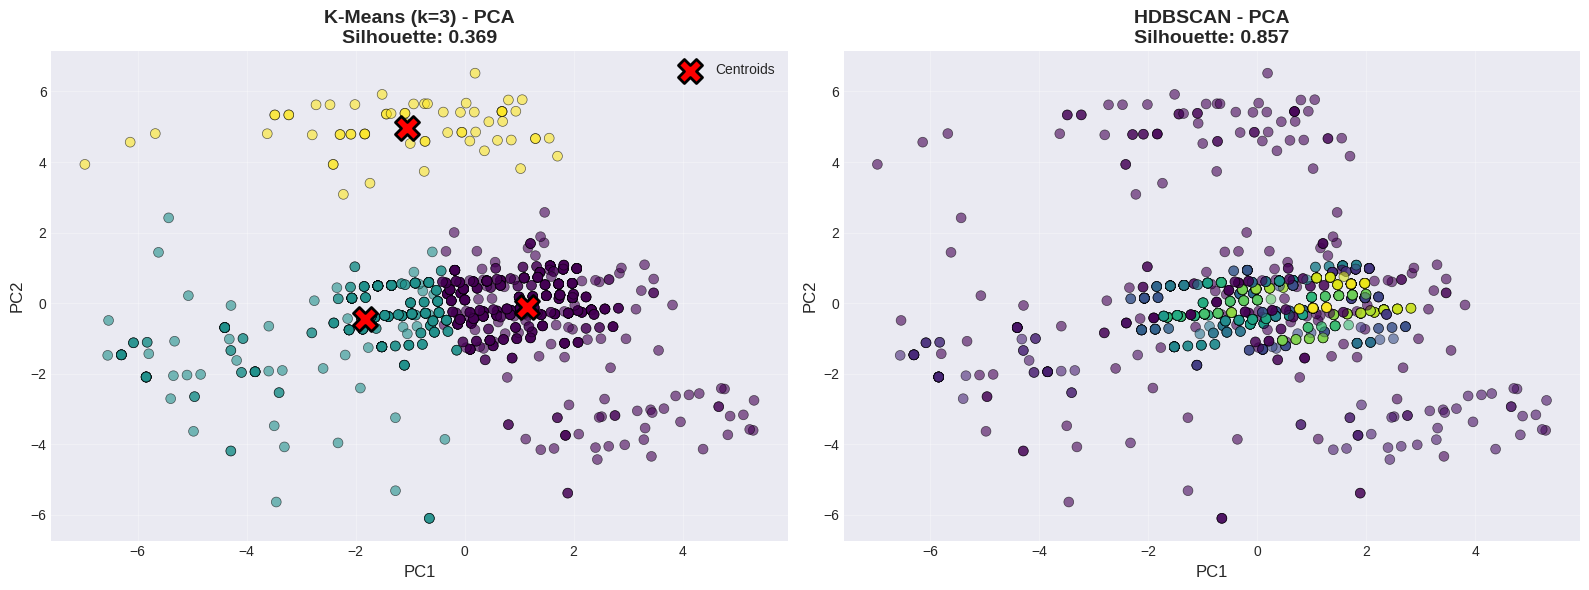

In [15]:
print("\n2.3 Visualisasi 2D (PCA)")
print("-" * 70)

# PCA
print("\n[A] Visualisasi dengan PCA")
pca = PCA(n_components=2, random_state=42)
data_pca = pca.fit_transform(df_scaled)

print(f"✓ PCA selesai")
print(f"  Variance explained: {pca.explained_variance_ratio_.sum():.2%}")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].scatter(data_pca[:, 0], data_pca[:, 1], c=kmeans_labels, cmap='viridis', s=50, alpha=0.6, edgecolors='k', linewidth=0.5)
axes[0].scatter(pca.transform(kmeans.cluster_centers_)[:, 0],
                pca.transform(kmeans.cluster_centers_)[:, 1],
                c='red', marker='X', s=300, edgecolors='black', linewidth=2, label='Centroids')
axes[0].set_xlabel('PC1', fontsize=12)
axes[0].set_ylabel('PC2', fontsize=12)
axes[0].set_title(f'K-Means (k={optimal_k}) - PCA\nSilhouette: {kmeans_sil:.3f}', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].scatter(data_pca[:, 0], data_pca[:, 1], c=hdbscan_labels, cmap='viridis', s=50, alpha=0.6, edgecolors='k', linewidth=0.5)
axes[1].set_xlabel('PC1', fontsize=12)
axes[1].set_ylabel('PC2', fontsize=12)
axes[1].set_title(f'HDBSCAN - PCA\nSilhouette: {hdbscan_sil:.3f}', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('clustering_pca.png', dpi=300, bbox_inches='tight')
plt.show()

Kode ini menggunakan Principal Component Analysis (PCA) untuk mengurangi dimensi data menjadi 2D dan memvisualisasikan hasil clustering K-Means dan HDBSCAN pada ruang 2D tersebut.

**Analisa Output Singkat:**

*   Visualisasi PCA menunjukkan bahwa **83.19% variansi** data asli dapat dijelaskan oleh dua komponen utama pertama (PC1 dan PC2), yang berarti PCA cukup efektif.
*   Pada visualisasi K-Means, terlihat 3 kelompok data. Ada pemisahan, tetapi juga tumpang tindih antar cluster, konsisten dengan Silhouette Score yang moderat.
*   Pada visualisasi HDBSCAN, terlihat pola clustering yang lebih terfragmentasi dengan banyak kelompok kecil yang padat dan beberapa titik noise. Visualisasi ini secara kualitatif mendukung metrik evaluasi HDBSCAN yang lebih baik (Silhouette Score tinggi), karena cluster-cluster yang terdeteksi tampak lebih padat dan terpisah di ruang PCA.

Visualisasi PCA memberikan gambaran visual yang mendukung temuan dari metrik evaluasi.

### 2.5 Visualisasi 2D TSNE


[B] Visualisasi dengan t-SNE
✓ t-SNE selesai


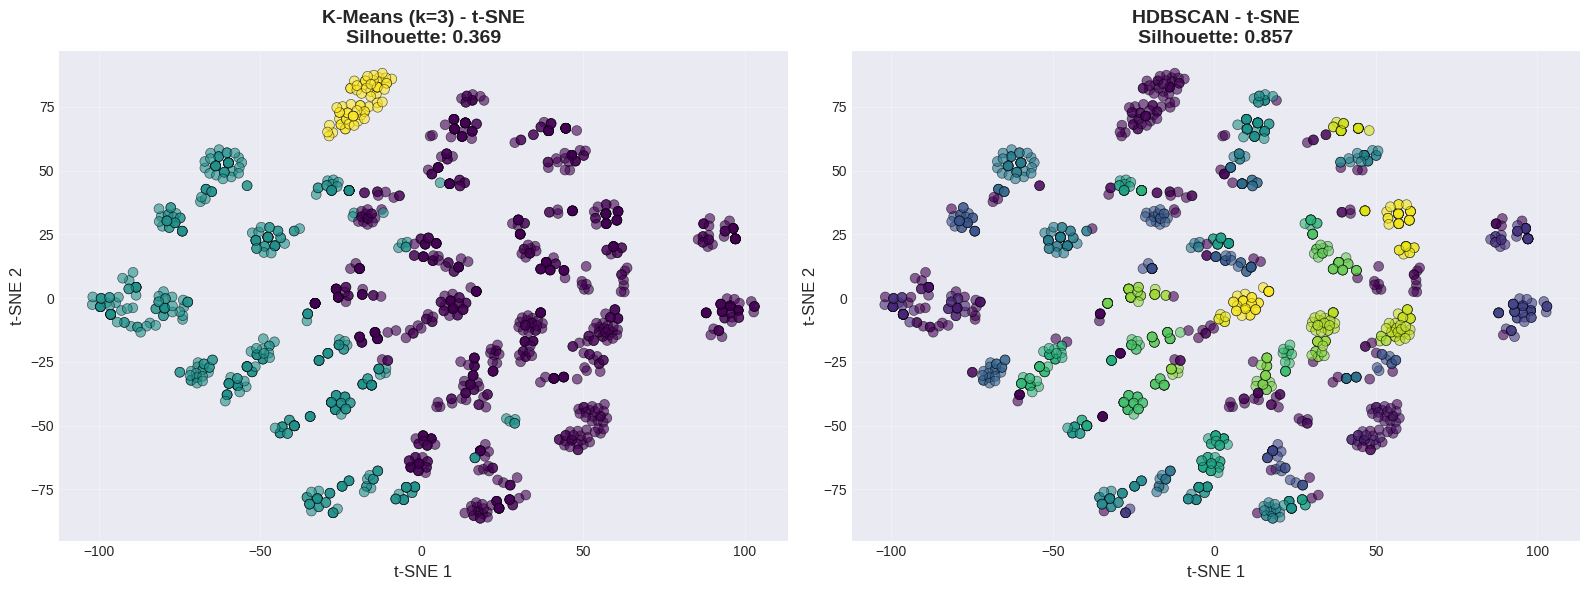

In [16]:
# t-SNE
print("\n[B] Visualisasi dengan t-SNE")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
data_tsne = tsne.fit_transform(df_scaled)

print(f"✓ t-SNE selesai")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].scatter(data_tsne[:, 0], data_tsne[:, 1], c=kmeans_labels, cmap='viridis', s=50, alpha=0.6, edgecolors='k', linewidth=0.5)
axes[0].set_xlabel('t-SNE 1', fontsize=12)
axes[0].set_ylabel('t-SNE 2', fontsize=12)
axes[0].set_title(f'K-Means (k={optimal_k}) - t-SNE\nSilhouette: {kmeans_sil:.3f}', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].scatter(data_tsne[:, 0], data_tsne[:, 1], c=hdbscan_labels, cmap='viridis', s=50, alpha=0.6, edgecolors='k', linewidth=0.5)
axes[1].set_xlabel('t-SNE 1', fontsize=12)
axes[1].set_ylabel('t-SNE 2', fontsize=12)
axes[1].set_title(f'HDBSCAN - t-SNE\nSilhouette: {hdbscan_sil:.3f}', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('clustering_tsne.png', dpi=300, bbox_inches='tight')
plt.show()

Kode ini menggunakan t-Distributed Stochastic Neighbor Embedding (t-SNE) untuk mengurangi dimensi data menjadi 2D dan memvisualisasikan hasil clustering K-Means dan HDBSCAN pada ruang 2D tersebut. t-SNE sangat baik dalam mempertahankan struktur lokal data.

**Analisa Output Singkat:**

*   Visualisasi K-Means pada ruang t-SNE kembali menunjukkan 3 kelompok, namun pemisahannya mungkin terlihat sedikit berbeda dibandingkan PCA karena t-SNE fokus pada mempertahankan kedekatan titik-titik data di ruang dimensi tinggi. Tumpang tindih antar cluster K-Means masih terlihat.
*   Visualisasi HDBSCAN pada ruang t-SNE seringkali menyoroti cluster-cluster yang lebih padat dan terpisah, dengan titik-titik noise tersebar di antaranya. Pola yang terlihat harus konsisten dengan temuan dari metrik evaluasi dan visualisasi PCA, yaitu HDBSCAN menemukan banyak kelompok kecil yang padat.

Visualisasi t-SNE memberikan perspektif visual lain yang melengkapi hasil PCA, membantu memahami bagaimana data dikelompokkan oleh K-Means dan HDBSCAN di ruang dimensi yang lebih rendah.

## 3. APPROXIMATE NEAREST NEIGHBOR (ANN)

### 3.1 Gunakan Annoy untuk mencari tetangga terdekat

In [18]:
print("\n3.1 Gunakan Annoy untuk mencari tetangga terdekat")
print("-" * 70)

# Build Annoy index
n_features = df_scaled.shape[1]
annoy_index = AnnoyIndex(n_features, 'euclidean')

for i in range(len(df_scaled)):
    annoy_index.add_item(i, df_scaled.iloc[i].values)

annoy_index.build(10)

print(f"✓ Annoy index berhasil dibangun")
print(f"  Dimensi: {n_features}")
print(f"  Jumlah item: {len(df_scaled)}")
print(f"  Metric: Euclidean")


3.1 Gunakan Annoy untuk mencari tetangga terdekat
----------------------------------------------------------------------
✓ Annoy index berhasil dibangun
  Dimensi: 7
  Jumlah item: 1389
  Metric: Euclidean


Kode ini menyiapkan struktur data (Annoy index) yang dioptimalkan untuk pencarian tetangga terdekat yang cepat dan efisien dalam ruang berdimensi tinggi. Ini sangat berguna untuk dataset besar di mana pencarian tetangga terdekat secara brute-force (membandingkan setiap titik dengan setiap titik lainnya) akan terlalu lambat.

**Analisa Output Singkat:**

*   Output menunjukkan bahwa Annoy index berhasil dibangun.
*   Index dibangun dengan **Dimensi: 7**, yang sesuai dengan jumlah fitur yang digunakan setelah standarisasi (`df_scaled`).
*   Index berisi **Jumlah item: 1389**, yang sesuai dengan jumlah sampel dalam dataset Anda.
*   **Metric: Euclidean** menunjukkan bahwa jarak antar titik diukur menggunakan jarak Euclidean standar.

Kode ini berhasil menyiapkan infrastruktur yang diperlukan untuk melakukan pencarian tetangga terdekat secara efisien menggunakan Annoy pada data fitur yang sudah diproses.

### 3.2 Tampilkan Output

In [19]:
print("\n3.2 Tampilkan Output")
print("-" * 70)

# Query 3-5 random points
np.random.seed(42)
n_queries = 5
query_indices = np.random.choice(len(df_scaled), n_queries, replace=False)
n_neighbors = 5

results = []

for idx, query_idx in enumerate(query_indices, 1):
    nearest_neighbors, distances = annoy_index.get_nns_by_item(query_idx, n_neighbors + 1, include_distances=True)
    nearest_neighbors = nearest_neighbors[1:]
    distances = distances[1:]

    print(f"\n[Query Point {idx}]")
    print(f"  • Index query point: {query_idx}")
    print(f"  • RGB Original: R={df_rgb.iloc[query_idx]['R']:.1f}, "
          f"G={df_rgb.iloc[query_idx]['G']:.1f}, "
          f"B={df_rgb.iloc[query_idx]['B']:.1f}")
    print(f"  • K-Means Cluster: {kmeans_labels[query_idx]}")
    print(f"  • HDBSCAN Cluster: {hdbscan_labels[query_idx]}")

    print(f"\n  • Daftar tetangga terdekat:")
    print(f"    {'Rank':<6} {'Index':<8} {'Distance':<12} {'RGB Original':<25}")
    print(f"    {'-'*60}")

    for i, (neighbor_idx, distance) in enumerate(zip(nearest_neighbors, distances), 1):
        rgb_str = f"({df_rgb.iloc[neighbor_idx]['R']:.0f}, " \
                  f"{df_rgb.iloc[neighbor_idx]['G']:.0f}, " \
                  f"{df_rgb.iloc[neighbor_idx]['B']:.0f})"

        print(f"    {i:<6} {neighbor_idx:<8} {distance:<12.4f} {rgb_str:<25}")

        results.append({
            'Query_Index': query_idx,
            'Neighbor_Rank': i,
            'Neighbor_Index': neighbor_idx,
            'Distance': distance,
            'KMeans_Cluster': kmeans_labels[neighbor_idx],
            'HDBSCAN_Cluster': hdbscan_labels[neighbor_idx]
        })


3.2 Tampilkan Output
----------------------------------------------------------------------

[Query Point 1]
  • Index query point: 558
  • RGB Original: R=151.0, G=153.8, B=106.4
  • K-Means Cluster: 0
  • HDBSCAN Cluster: 74

  • Daftar tetangga terdekat:
    Rank   Index    Distance     RGB Original             
    ------------------------------------------------------------
    1      555      0.0000       (151, 154, 106)          
    2      558      0.0000       (151, 154, 106)          
    3      559      0.0000       (151, 154, 106)          
    4      569      0.0000       (151, 154, 106)          
    5      579      0.0000       (151, 154, 106)          

[Query Point 2]
  • Index query point: 168
  • RGB Original: R=144.0, G=149.0, B=106.4
  • K-Means Cluster: 1
  • HDBSCAN Cluster: 39

  • Daftar tetangga terdekat:
    Rank   Index    Distance     RGB Original             
    ------------------------------------------------------------
    1      160      0.0000      

Kode ini mengambil beberapa titik data secara acak dan menggunakan Annoy index yang sudah dibangun untuk mencari tetangga terdekat (berdasarkan jarak Euclidean di ruang fitur yang distandarisasi) untuk setiap titik query tersebut.

**Analisa Output Singkat:**

*   Output menampilkan informasi untuk **5 titik query** yang dipilih secara acak.
*   Untuk setiap titik query, ditampilkan index aslinya, nilai RGB originalnya, serta cluster K-Means dan HDBSCAN tempat titik tersebut berada. Ini membantu mengaitkan hasil ANN dengan hasil clustering.
*   Daftar **5 tetangga terdekat** (selain titik query itu sendiri, jika termasuk) ditampilkan untuk setiap titik query.
*   Untuk setiap tetangga terdekat, ditampilkan **Rank** (urutan kedekatan), **Index** data tetangga tersebut, **Distance** (jarak dari titik query di ruang fitur yang distandarisasi), dan nilai **RGB Original** dari tetangga tersebut.

Analisis output menunjukkan bahwa Annoy berhasil menemukan titik-titik data lain yang sangat mirip (memiliki jarak yang kecil) dengan titik query yang dipilih. Perhatikan bahwa untuk banyak query, tetangga terdekat memiliki jarak 0.0000, yang kemungkinan besar menunjukkan bahwa ada duplikat data atau titik-titik yang sangat identik di dataset. Ini adalah temuan menarik dari hasil ANN. Selain itu, Anda bisa mengamati apakah tetangga terdekat cenderung berada di cluster K-Means atau HDBSCAN yang sama dengan titik query, yang dapat memberikan wawasan tambahan tentang struktur data.